# 2.6 parallelization

# 1 overview
1. The growth of CPU clock speed (i.e., the speed at which a single chain of logic can be run) has slowed dramatically in recently years.
   - This is unlikely to change in the near future, due to inherent physical limitations on the construction of chips and circuit boards.
2. Chip designers and computer programmers have responded to the slowdown by seeking a different path to fast execution: **parallelization**.
   - Hardware makers have increased the number of cores (physical CPUs) embedded in each machine.
   - For programmers, the challenge has been to exploit these multiple CPUs by running many processes in parallel (i.e., simultaneously).
     - This is particularly important in scientific programming, which requires handling
       - large amounts of data and
       - CPU intensive simulations and other calculations.
     - In this lecture(**PI:,**) we discuss parallelization for scientific computing, with a focus on 
       - the best tools for parallelization in Python and
       - how these tools can be applied to quantitative economic problems.

In [1]:
!pip install --upgrade quantecon
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

%matplotlib inline

Requirement already up-to-date: quantecon in /Users/shuhu/anaconda3/lib/python3.7/site-packages (0.4.6)


# 2 types of parallelization

1. Large textbooks have been written on different approaches to parallelization(**PI:,**) but we will keep a tight focus on what's most useful to us.
   - We will briefly review the **two main** kinds of parallelization in common use in scientific computing and discuss their **pros and cons**.

## 2.1 multiprocessing

1. Multiprocessing means concurrent execution of multiple processes using more than one processor.
   - **A process** is a chain of instructions (i.e., a program).
   - Multiprocesing can be carried out on **one machine with multiple CPUs** or on **a collection of machines connected by a network**.
     - In the latter case, the collection of machines is usually called a **cluster**.
   - With multiprocessing, each process has its own memory space, although the physical memory chip might be shared.
   

## 2.2 multithreading

1. Multithreading is similar to multiprocessing, except that, during execution, the **threads all share the same memory space**.
   - Native Python struggles to implement multithreading due to some legacy design features.
   - But this is not a restriction for scientific libraries like NumPy and Numba.
     - Functions implemented from these libraries and JIT-compiled code run in low level execution environments where Python's legacy restrictions don't apply.

## 2.3 advantages and disadvantages

1. Multithreading is more lightweight because most system and memory resources are shared by the threads.
2. In addition, the fact that multiple threads all access a shared pool of memory is extremely convenient for numerical programming.
3. On the other hand, multiprocessing is more flexible and can be distributed across clusters.
   - For the great majority of what we do in these lectures, multithreading will suffice.

# 3 implicit multithreading in numpy

1. Actually, we have already been using multithreading in our Python code, although we might not have realized it.
   - This is because NumPy cleverly implements multithreading in a lot of its compiled code.
   - Let's look at some examples to see this in action.
   
## 3.1 a matrix operation

1. The next piece of code computes the eigenvalues of a large number of randomly generated matrices, see Program 1.
   - It takes a few seconds to run.
   - We can see that 4 of the 8 cores (**PI1: threads**) are running at full speed.
     - This is because NumPy's `eigvals` routine neatly splits up the tasks and distributes them to different threads.

In [2]:
# Program 1

n = 20
m = 1000

for i in range(n):
    X = np.random.randn(m, m)
    λ = np.linalg.eigvals(X)

## 3.2 a multithreading ufunc

1. Over the last few years, **NumPy** has managed to push this kind of multithreading out to more and more operations.
   - e.g., let's return to a maximization problem discussed in lecture 2.1, see Program 2.
   - If we have a system monitor, such as htop (Linux/Mac) or perfmon (Windows) (**PI2: a link about tutorials should be attached here? htop:(https://hisham.hm/htop/); update "performance monitor" for windows 10, links(https://docs.microsoft.com/en-us/previous-versions/windows/it-pro/windows-server-2008-R2-and-2008/cc749154(v=ws.11)) about 'perfmon' are outdated**), then try running this and then observing the load on our CPUs.
     - We will probably need to bump up the grid size to see large effects.
   - The output shows that the **operation is successfully distributed across multipe threads**.
     - This is one of the reasons why the vectorized code above is fast.

In [3]:
# Program 2: Numpy

def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 5000)
x, y = np.meshgrid(grid, grid)

%timeit np.max(f(x, y))

511 ms ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3.3 a comparison with numba

1. To get some basis for comparison for the last example, let's try the same thing with **Numba**.
   - In fact(**PI:,**) there is an easy way to do this, since Numba can also be used to create custom ufuncs with the `@vectorize` decorator, see Program 3.
     - At least on our machine, the difference in the speed between the Numba (**PI3: NumPy**) version and the vectorized NumPy version (**PI3: Numba here**) shown in Program 2-3 is not large.
   - But there's quite a bit going on here, so let's try to **break down what is happening**.
     - Both Numba and NumPy use efficient machine code that's specialized to these floating(**PI:-**)point operations.
     - However, the code NumPy uses is, in some ways, less efficient.
       - The reason is that, in NumPy, the operation `np.cos(x**2 + y**2) / (1 + x**2 + y**2) ` generates several **intermediate arrays**.
         - e.g., a new array is created when `x**2` is calculated.
         - The same is true when `y**2` is calculated, and then `x**2 + y**2` and so on.
       - Numba avoids creating all these intermediate arrays by compiling one function that is specilized to the entire operation.
     - But if this is true, then why isn't the Numba code faster?
       - The reason is that NumPy makes up for its disadvantages with implicit multithreading, as we've just discussed.

In [5]:
# Program 3: 
from numba import vectorize

@vectorize
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y))  # Run once to compile; Why this? PI4
%timeit np.max(f_vec(x, y))

279 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3.4 multithreading a numba ufunc

1. Can we get both of these advantages at once?
   - In other words, can we pair
     - the **efficiency** of Numba's highly specialized JIT(**PI:-**)compiled function and
     - the speed gains from parallelization obtained by NumPy's **implicit multithreading**?
   - It turns out that we can, by adding some **type information plus `target= 'parallel'`**, see Program 4.
     - Now our code runs significantly faster than the NumPy version.

In [8]:
# Program 4 

@vectorize('float64(float64, float64)', target='parallel')
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

%timeit np.max(f_vec(x, y))

65.5 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# 4 multithreaded loops in Numba

1. We just saw one approach to parallelization in Numba, using the `parallel` flag in `@vectorize`.
   - This is neat but, it turns out, not well suited to many problems we consider.
2. Fortunately, **Numba** provides another approach to multithreading that will work for us almost everywhere parallelization is possible.
   - To illustrate it, let's look at a simple, single-threaded (i.e., non-parallelized) piece of code, see Program 1.
     - The code simulates updating the wealth $w_t$ of a household via the rule
     $$
     w_{t+1} = R_{t+1} s w_t + y_{t+1}
     $$
     - Here
       - $R$ is the gross rate of return on assets,
       - $s$ is the savings rate of the household and,
       - $y$ is labor income.
     - We model both $R$ and $y$ as independent draws from a lognormal distribution.
   - Let's have a look at how wealth evolves under this rule, see Program 2.
   - Now let's suppose that we have a large population of households and we want to know what median wealth will be.
     - This is not easy to solve with pencil and paper, so we will use simulation instead.
       - In particular, we will simulate a large number of households, and then calculate (**PI:the**) median wealth for this group.
       - Suppose we are interested in the long-run average of this median over time.
         - It turns out that, for specification that we've chosen above, we can calculate this (**PI: one more "this"**) by taking a one-period snapshot of what has happened to median wealth of the group at the end of a long simulation.
         - Moreover, provided the simulation period is long enough, initial conditions don't matter.
           - This is due to something called **ergodicity**, which we will discuss later on.
         - In summary, see Program 3-4, 
           - we are going to simulate $50,000$ households by 
             - arbitrarily setting initial wealth to $1$ and
             - simulating forward in time for $1,000$ periods.
           - then we will calculate (**PI:the**) median wealth at the end period.
         - To speed this up, we are going to parallelize it via multithreading.
           - To do so, we add the `parallel=True` flag and change `range` to `prange`, see Program 4.
           - The speed-up is significant.

In [2]:
# Program 1

from numpy.random import randn
from numba import njit

@njit
def h(w, r=0.1, s=0.3, v1=0.1, v2=1.0):
    
    # Draw shocks (PI6: why they look like this?)
    R = np.exp(v1 * randn()) * (1 + r)
    y = np.exp(v2 * randn())
    
    # Update wealth
    w = R * s * w + y
    return w

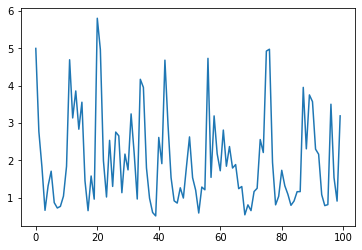

In [3]:
# Program 2 PI7: Add labels 

fig, ax = plt.subplots()

T = 100
w = np.empty(T)
w[0] = 5
for t in range(T-1):
    w[t+1] = h(w[t])
    
ax.plot(w)
plt.show() # PI7: add this line?

In [10]:
# Program 3
@njit
def compute_long_run_median(w0=1, T=1000, num_reps=50_000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        w = w0
        for t in range(T):
            w = h(w)
        obs[i] = w
        
    return np.median(obs)

%timeit compute_long_run_median()

3.69 s ± 40.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# Program 4

from numba import prange

@njit(parallel=True)
def compute_long_run_median_parallel(w0=1, T=1000, num_reps=50_000):
    obs = np.empty(num_reps)
    for i in prange(num_reps): # Why here
        w = w0
        for t in range(T):     # Can we change this to prange?
            w = h(w)
        obs[i] = w
        
    return np.median(obs)
%timeit compute_long_run_median_parallel()

572 ms ± 8.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 4.1 a warning

1. Parallelization works well in the outer loop of the last example because the **individual tasks inside the loop are independent of each other** (**???**).
   - If this independent fails(**PI:,**) then parallelization is often problematic.
     - e.g., each step inside the inner loop depends on the last step, so independence fails, and this is why we use (**PI:the**) ordinary `range` instead of `prange`.
   - When we see using `prange` in later lectures, it is because the independence of tasks hold(**PI:s**) true.
   - When we see using (**PI:the**) ordinary `range` in a jitted function, it is either because the speed gain from parallelization is small or because independence fails.

# 5 exercises

1. Generally speaking, parallelization is less effective when the individual tasks to be parallelized are very small relative to total execution time (**PI8: something wrong with the code.**).
   - This is due to overheads associated with spreading all of these small tasks across multiple CPUs.
   - Nevertheless, with suitable hardware, it is possible to get nontrivial speed gains in this exercise.

In [19]:
def π(length_ts=10000, r=1):
    i = 0
    s_c = 0
    while i <= length_ts: # We can replace it with 
        u = [np.random.uniform(0,1) for i in range(2)]
        x, y = u
        a = x**2 + y**2
        if a <= 1:
            s_c += 1
        i += 1
    s = s_c / length_ts
    return (s * 4) / (r**2)

In [20]:
from numba import jit

π_numba = jit(π)

In [22]:
%time π_numba()

CPU times: user 5.53 ms, sys: 57 µs, total: 5.59 ms
Wall time: 5.58 ms


3.1324

In [15]:
from random import uniform
from numba import prange

@njit(parallel=True)
def calculate_pi(n=1_000_000):
    count = 0
    for i in prange(n):
        u, v = uniform(0, 1), uniform(0, 1)
        d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
        if d < 0.5:
            count += 1

    area_estimate = count / n
    return area_estimate * 4

In [23]:
%time calculate_pi()

CPU times: user 34.2 ms, sys: 4.11 ms, total: 38.3 ms
Wall time: 4.94 ms


3.14108

2. By switching parallelization on and off (selecting `True` or `False` in the `@jnit` (**PI8: `@njit`**) annotation), we can test the speed gain that multithreading provides on top of JIT compilation.

3. On our workstation, we find that parallelization increases execution speed by a factor of 2 or 3.
   - If we are executing locally, then we would get different numbers, depending mainly on the number of CPUs on our machine.
